In [1]:
%reload_ext cairo_jupyter

run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed True


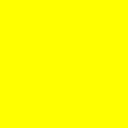

run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
run once  source_changed False
fin


In [1]:
import asyncio
import re

from aiohttp import web

import cairo

from contextlib import contextmanager
from io import BytesIO
from pathlib import Path

from IPython.display import display, clear_output

FORMAT_PS = 'ps'
FORMAT_PDF = 'pdf'
FORMAT_PNG = 'png'
FORMAT_SVG = 'svg'
FORMAT_SVG_XML = 'svg_xml'

VALID_FORMATS = [FORMAT_PNG, FORMAT_SVG, FORMAT_SVG_XML]

ERROR_UNSUPPORTED_FORMAT = "Format must be FORMAT_PDF, FORMAT_PNG, FORMAT_PS, FORMAT_SVG or FORMAT_SVG_XML"

class SourceChangedEvent:
    def __init__(self, source):
        self.source = source
        self._event = asyncio.Event()

    async def wait(self):
        await self._event.wait()
    
    def source_executed(self, success, errors=None):
        """
        """
        self.success = success
        self.errors = errors
        self._event.set()


class BufferedCanvas:
    """
    Uses a RecordingSurface to keep track of the draw state on the current frame/page,
    and allowing it to be copied to various outputs as needed.
    """
    def __init__(self, extents=None):
        """
        :param dimensions: Extents of recording surface, or None for unbounded.
        """
        self.surface = cairo.RecordingSurface(cairo.CONTENT_COLOR_ALPHA, extents) 
    
    def copy_to_surface(self, surface):
        # Draw self.surface onto another surface
        ctx = cairo.Context(surface)
        ctx.set_source_surface(self.surface)
        ctx.paint()
        del ctx

    def save(self, f, format=None, *args, **kwargs):
        """
        Output current canvas frame, using cairo to save.
        
        :param f: buffer or filename.
        """
        if not format:
            if isinstance(f, str):
                suffix = Path(f).suffix
                format = suffix.rsplit('.')[-1] or FORMAT_PNG
            else:
                format = FORMAT_PNG
        
        extents = self.surface.ink_extents()  # TODO: handle ink_extents that don't start at 0, 0
        dimensions = extents[2], extents[3]
        if format == FORMAT_PNG:
            # PNG is special: write_to_png is called after drawing.
            surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, int(dimensions[0]), int(dimensions[1]))
            self.copy_to_surface(surface)
            surface.write_to_png(f)
            return
        elif format == FORMAT_PDF:
            surface = cairo.PDFSurface(f, *dimensions)
        elif format == FORMAT_PS:
            surface = cairo.PDFSurface(f, *dimensions)
        elif format in (FORMAT_SVG, FORMAT_SVG_XML):
            surface = cairo.SVGSurface(f, *dimensions)
        else:
            raise ValueError(ERROR_UNSUPPORTED_FORMAT)
            
        self.copy_to_surface(surface)
        surface.flush()  # Ensure data written to file or buffer.

    def display(self, format=None, *args, **kwargs):
        """
        """
        from IPython.display import Image, SVG, display as _display

        if format in (FORMAT_PDF, FORMAT_PS):
            raise NotImplementedError(f"{format} is not yet supported.")
        
        if format is None:
            if not args and self.surface.ink_extents() == (.0, .0, .0, .0):
                format = FORMAT_SVG  # 0 size images are legal in SVG.
            else:
                format = FORMAT_PNG
        
        with BytesIO() as buffer:
            self.save(buffer, format, *args)
            if format == FORMAT_PNG:
                _display(Image(data=buffer.getvalue()))
            elif format == FORMAT_SVG:
                _display(SVG(buffer.getvalue()))
            elif format == FORMAT_SVG_XML:
                try:
                    from display_xml import XML
                except ImportError:
                    raise ImportError('Install display_xml to output as XML:  $ pip3 install display_xml')

                _display(XML(buffer.getvalue()))
            else:
                # Included for completeness, should have been caught by the call to save().
                raise ValueError(ERROR_UNSUPPORTED_FORMAT)
    
    @contextmanager
    def recording_surface(self, extents=None):
        """
        While context is active, drawing is directed to a RecordingSurface,
        if no exceptions occur, then the content is painted onto the canvases
        original surface.
        """
        _surface = self.surface
        self.surface = surface = cairo.RecordingSurface(cairo.CONTENT_COLOR_ALPHA, extents)
        try:
            yield surface
        except:
            raise
        finally:
            self.surface = _surface
        
        # No exceptions were raised, draw
        cr = cairo.Context(_surface)
        cr.set_source_surface(surface)
        cr.paint()



class ShoebotContext:
    """
    Define what is visible during the execution of a Shoebot script.
    
    Methods here, delegate drawing operations to the ShoebotCanvas.
    """
    def __init__(self, canvas, ns=None):
        if ns is not None:
            self._ns = {}
        else:
            self._ns = ns
            
        self._canvas = canvas
        self._fillcolor = (1., 0., 0.)
    
    def fill(self, *args):
        self._fillcolor = args
            
    def rect(self, x, y, w, h):
        ctx = cairo.Context(self._canvas.surface)
        ctx.set_source_rgb(*self._fillcolor)
        ctx.rectangle(x, y, x+w, y+h)
        ctx.fill()
        
def context_as_dict(context):
    """
    :param context: ShoebotContext.
    """
    return {
        name: getattr(context, name)
        for name in dir(context) 
        if not name.startswith('_')
    }
        

class ShoebotRunner:
    def __init__(self, **kwargs):
        self.canvas = BufferedCanvas(**kwargs)
        self.context = ShoebotContext(self.canvas)
        
        self.source_change_queue = asyncio.Queue()

    async def update_source(self, source):
        """
        Update source code.
        
        Blocks until source is executed by main loop.
        """
        event = SourceChangedEvent(source)
        await self.source_change_queue.put(event)
        await event.wait()
        return event
        
    def _get_updated_source(self):
        """
        If source was updated externally, return a SourceChangedEvent
        otherwise return None.
        """
        # TODO: Handle multiple events, by taking the last
        #       one and informing others they have failed.
        try:
            return self.source_change_queue.get_nowait()
        except asyncio.QueueEmpty:
            return
    
    async def run_once(self, code):        
        # TODO: During first frame canvas is already cleared.
                
        # TODO: During subsequent frames if canvas should be
        # cleared use show_page, otherwise copy_page  for outputs.
        with self.canvas.recording_surface() as surface:
            _vars = dict(context_as_dict(self.context))
            exec(code, _vars, _vars)

        await asyncio.sleep(0)
        return self.canvas
    
    async def run_multiple(self, code):
        await asyncio.sleep(0)
    
    async def run(self, code):
        while True:
            # TODO - following should be in run, with loop
            source_changed = self._get_updated_source()
            print("run once  source_changed", bool(source_changed))
            if source_changed:
                ##self.canvas.display()  # for debug
                code = source_changed.source

            try:
                await self.run_once(code)
            except Exception as e:
                if source_changed:
                    source_changed.source_executed(True)
                    self.source_change_queue.task_done()
            else:
                if source_changed:
                    # TODO - run new source here
                    source_changed.source_executed(True)
                    self.source_change_queue.task_done()
                
            #clear_output()
            if source_changed:
                self.canvas.display()  # TODO - just for prototyping.

            await asyncio.sleep(1)

    
    
## Web API
class WebAPI:
    def __init__(self, runner):
        self.runner = runner
        
    async def upload_source(self, request):
        """
        Revieve source upload and pass to shoebot
        runner.
        
        Wait until source ie executed or returns an
        error, then return status,
        """
        data = await request.post()

        source = data['file']

        if isinstance(source, str):
            unescape_characters = data.get('unescape', "true").lower() in ["true", "yes"]

            # To aid development, you can send source in this field.
            if unescape_characters:
                source_content = source.replace('\\n', '\n')
            else:
                source_content = source
        else:
            filename = source.filename
            source_file = source.file
            source_content = source_file.read()

        try:
            code = compile(source_content, "<string>", "exec")
        except Exception as e:
            return web.json_response({"compiled": {"success": False, "errors": str(e)}})
        
        source_changed = await self.runner.update_source(source_content)
        return web.json_response({"compiled": source_changed.success,
                             "ran": source_changed.success,
                             "errors": source_changed.errors or []})
    
    def routes(self):
        return [web.post("/source", self.upload_source)]

async def web_api_runner(runner, host="localhost", port=7780):
    api = WebAPI(runner)
    app = web.Application()
    app.add_routes([*api.routes()])

    app_runner = web.AppRunner(app)
    await app_runner.setup()
    site = web.TCPSite(app_runner, host, port)
    await site.start()
    
    return site
    
    
## Usage
code = """\
rect(0, 0, 45, 45)
"""
runner = ShoebotRunner(extents=(0, 0, 128, 128))

async def _run_and_display():
    await runner.run(code)
    
async def main():
    web_api = await web_api_runner(runner)
    try:
        await _run_and_display()
    except asyncio.CancelledError:
        await web_api.stop()

          
await main()
print("fin")

In [3]:
import inspect

dir(runner.context)

#runner.context.__dict__.keys()

{name: getattr(runner.context, name) for name in dir(runner.context) if not name.startswith('_')}

{'fill': <bound method ShoebotContext.fill of <__main__.ShoebotContext object at 0x7f1f6045f460>>,
 'rect': <bound method ShoebotContext.rect of <__main__.ShoebotContext object at 0x7f1f6045f460>>}